In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv("train.csv")

# Create a copy to work on
df_cleaned = df.copy()

# Handle specific columns first
df_cleaned['Alley'] = df_cleaned['Alley'].fillna('NoAlley')
df_cleaned['MasVnrType'] = df_cleaned['MasVnrType'].fillna('NoMasonry')
df_cleaned['LotFrontage'] = df_cleaned['LotFrontage'].fillna(0)

# General rule-based cleaning
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any():
        if df_cleaned[col].dtype == 'object':
            df_cleaned[col] = df_cleaned[col].fillna(f'No{col}')
        else:
            df_cleaned[col] = df_cleaned[col].fillna(0)

# Final check to confirm all NaNs are handled
assert df_cleaned.isnull().sum().sum() == 0
df_cleaned.head(9)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NoAlley,IR1,Lvl,AllPub,...,0,NoPoolQC,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NoAlley,Reg,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,8,2007,WD,Normal,307000
7,8,60,RL,0.0,10382,Pave,NoAlley,IR1,Lvl,AllPub,...,0,NoPoolQC,NoFence,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NoAlley,Reg,Lvl,AllPub,...,0,NoPoolQC,NoFence,NoMiscFeature,0,4,2008,WD,Abnorml,129900


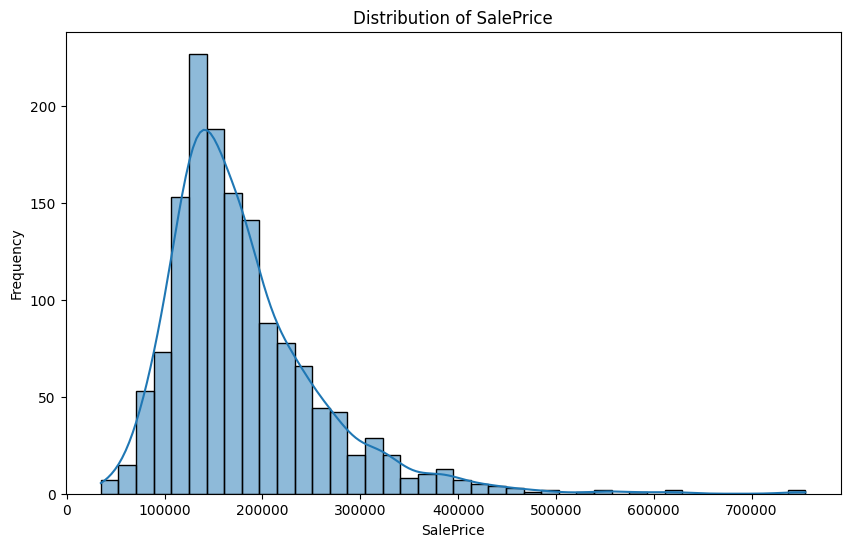

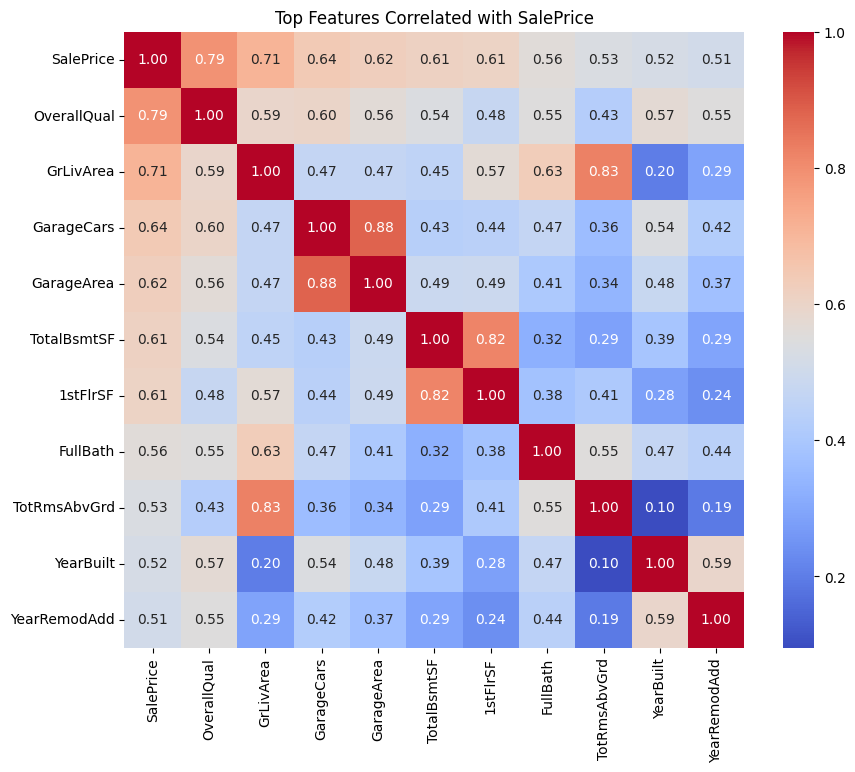

(1.8828757597682129,
 SalePrice       1.000000
 OverallQual     0.790982
 GrLivArea       0.708624
 GarageCars      0.640409
 GarageArea      0.623431
 TotalBsmtSF     0.613581
 1stFlrSF        0.605852
 FullBath        0.560664
 TotRmsAbvGrd    0.533723
 YearBuilt       0.522897
 YearRemodAdd    0.507101
 Name: SalePrice, dtype: float64)

In [53]:
# 1. Distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['SalePrice'], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Check skewness
saleprice_skew = df_cleaned['SalePrice'].skew()

# 2. Correlation with SalePrice
numerical_features = df_cleaned.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()

# Top features most correlated with SalePrice
top_corr = correlation_matrix['SalePrice'].abs().sort_values(ascending=False).head(11)

# Plot correlation heatmap
top_corr_features = top_corr.index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top Features Correlated with SalePrice")
plt.show()

saleprice_skew, top_corr

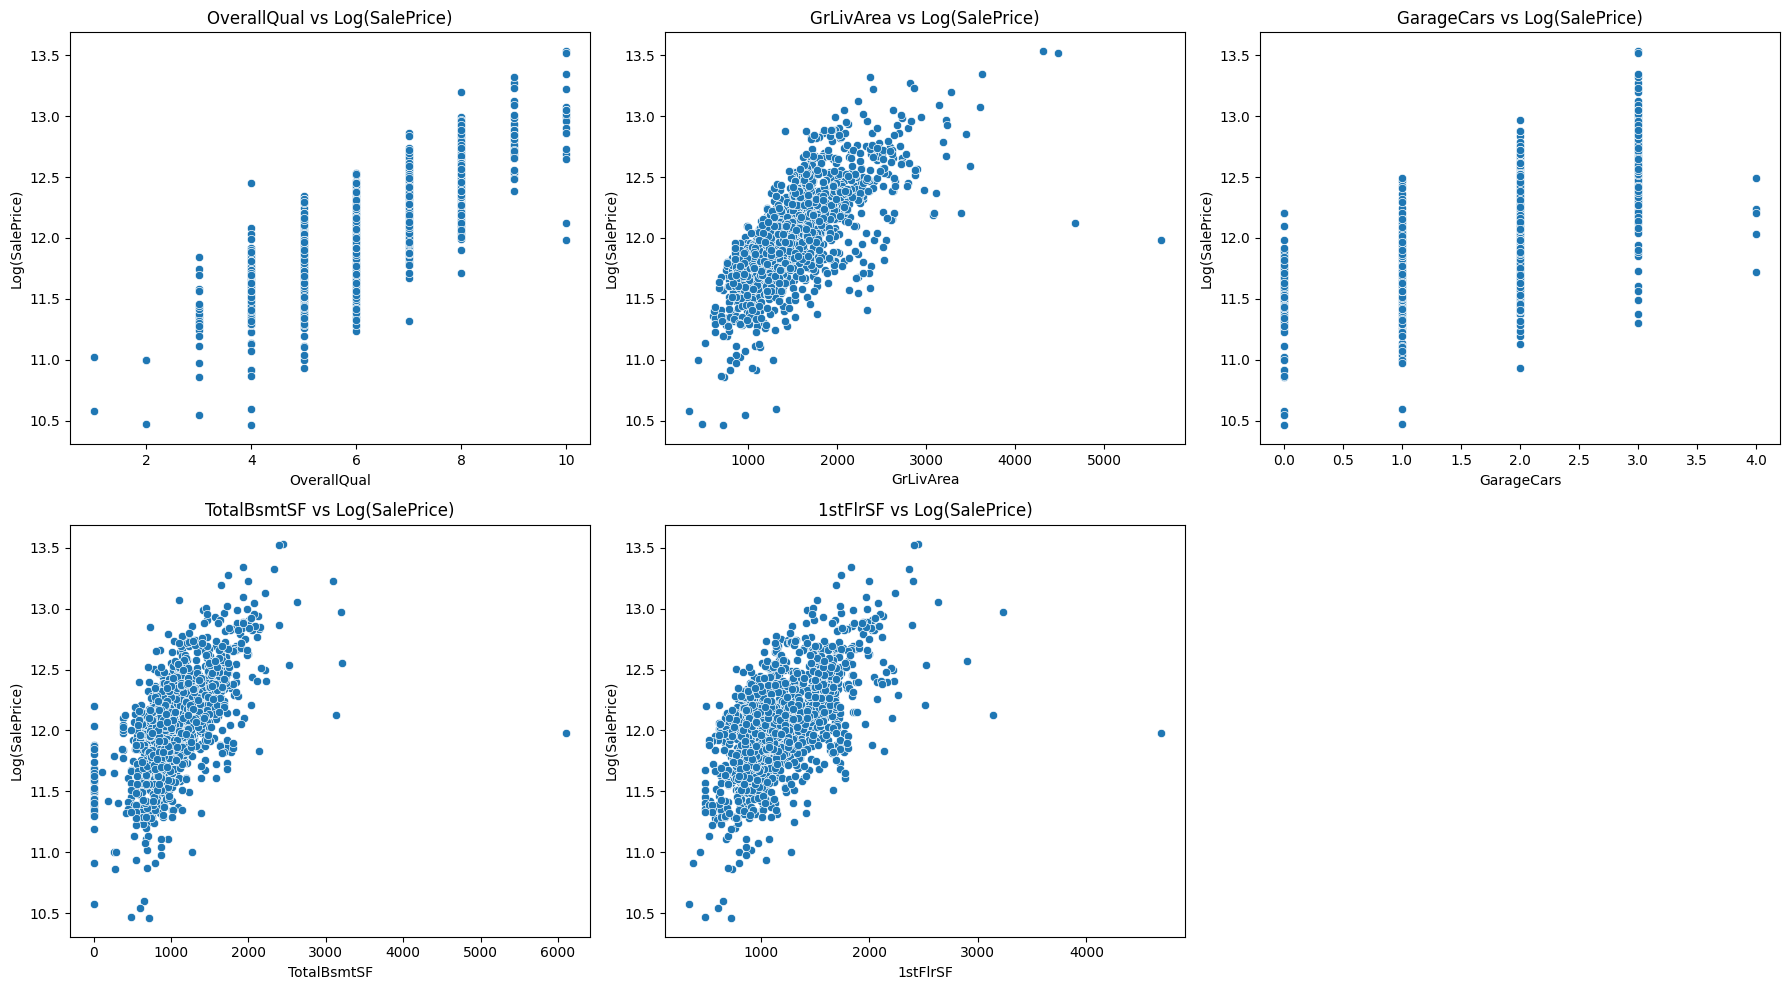

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Log-transform SalePrice
df_cleaned["LogSalePrice"] = np.log1p(df_cleaned["SalePrice"])

# Visualize top correlated features vs. LogSalePrice
top_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, feature in enumerate(top_features):
    sns.scatterplot(x=df_cleaned[feature], y=df_cleaned["LogSalePrice"], ax=axs[i])
    axs[i].set_title(f'{feature} vs Log(SalePrice)')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Log(SalePrice)')

# Hide unused subplot
for j in range(len(top_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [55]:
# Create engineered features
df_cleaned['HouseAge'] = df_cleaned['YrSold'] - df_cleaned['YearBuilt']
df_cleaned['RemodAge'] = df_cleaned['YrSold'] - df_cleaned['YearRemodAdd']
df_cleaned['TotalSF'] = df_cleaned['TotalBsmtSF'] + df_cleaned['1stFlrSF'] + df_cleaned['2ndFlrSF']

# Total number of bathrooms (weighted: full = 1, half = 0.5)
df_cleaned['TotalBath'] = (
    df_cleaned['FullBath'] +
    0.5 * df_cleaned['HalfBath'] +
    df_cleaned['BsmtFullBath'] +
    0.5 * df_cleaned['BsmtHalfBath']
)

# Total porch area
df_cleaned['TotalPorchSF'] = (
    df_cleaned['OpenPorchSF'] +
    df_cleaned['EnclosedPorch'] +
    df_cleaned['3SsnPorch'] +
    df_cleaned['ScreenPorch']
)

# Binary indicators for features that may or may not be present
df_cleaned['HasPool'] = (df_cleaned['PoolArea'] > 0).astype(int)
df_cleaned['HasFireplace'] = (df_cleaned['Fireplaces'] > 0).astype(int)
df_cleaned['HasGarage'] = (df_cleaned['GarageArea'] > 0).astype(int)

# Optional: preview the new features
print(df_cleaned[['HouseAge', 'RemodAge', 'TotalSF', 'TotalBath', 'TotalPorchSF', 'HasPool', 'HasFireplace', 'HasGarage']].head())


   HouseAge  RemodAge  TotalSF  TotalBath  TotalPorchSF  HasPool  \
0         5         5     2566        3.5            61        0   
1        31        31     2524        2.5             0        0   
2         7         6     2706        3.5            42        0   
3        91        36     2473        2.0           307        0   
4         8         8     3343        3.5            84        0   

   HasFireplace  HasGarage  
0             0          1  
1             1          1  
2             1          1  
3             1          1  
4             1          1  


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Define target and features
y = df_cleaned["LogSalePrice"]
X = df_cleaned.drop(columns=["SalePrice", "LogSalePrice", "Id"])

# 2. Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Preprocessing: One-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols)
    ],
    remainder="passthrough"
)

# 5. Linear Regression model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# 8. Print important model parameters
regressor = model.named_steps["regressor"]
print("Intercept:", regressor.intercept_)
print("Number of Coefficients:", len(regressor.coef_))
print("RMSE (log-transformed SalePrice):", rmse)


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Intercept: -1198924.3331931653
Number of Coefficients: 309
RMSE (log-transformed SalePrice): 94.15156865625208


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Define the target and features
y = df_cleaned["LogSalePrice"]
X = df_cleaned.drop(columns=["SalePrice", "LogSalePrice", "Id"])

# 2. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Preprocessor: one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols)
    ],
    remainder="passthrough"  # Keep numerical columns as they are
)

# 5. Random Forest model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# 8. Print evaluation results
print("RMSE (log-transformed SalePrice):", rmse)


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE (log-transformed SalePrice): 0.14634938285411397


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np

# 1. Define the target and features
y = df_cleaned["LogSalePrice"]
X = df_cleaned.drop(columns=["SalePrice", "LogSalePrice", "Id"])

# 2. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Preprocessor for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols)
    ],
    remainder="passthrough"  # Leave numerical columns as-is
)

# 5. XGBoost Regressor pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# 8. Output results
print("RMSE (log-transformed SalePrice):", rmse)


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RMSE (log-transformed SalePrice): 0.1504158328801102


In [59]:
from lightgbm import LGBMRegressor

lgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LGBMRegressor(n_estimators=100, random_state=42))
])

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("LightGBM RMSE:", rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3893
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 200
[LightGBM] [Info] Start training from score 12.030658
LightGBM RMSE: 0.14034033611638913


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Use raw (non-one-hot) data
X = df_cleaned.drop(columns=["SalePrice", "LogSalePrice", "Id"])
y = df_cleaned["LogSalePrice"]

# Identify categorical columns and their indices
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CatBoost model
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_feature_indices,
    verbose=0,
    random_seed=42
)

# Train and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("CatBoost RMSE:", rmse)


CatBoost RMSE: 0.1362353335230914


In [61]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Define Ridge model
ridge_model = Ridge(alpha=1.0, random_state=42)

# Create and evaluate pipeline
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ridge_model)
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)

print("Ridge RMSE:", ridge_rmse)


Ridge RMSE: 0.13104311607910063


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [62]:
from sklearn.linear_model import Lasso

# Define Lasso model
lasso_model = Lasso(alpha=0.01, random_state=42, max_iter=10000)

# Create and evaluate pipeline
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", lasso_model)
])

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)

print("Lasso RMSE:", lasso_rmse)


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Lasso RMSE: 0.15309174281899812


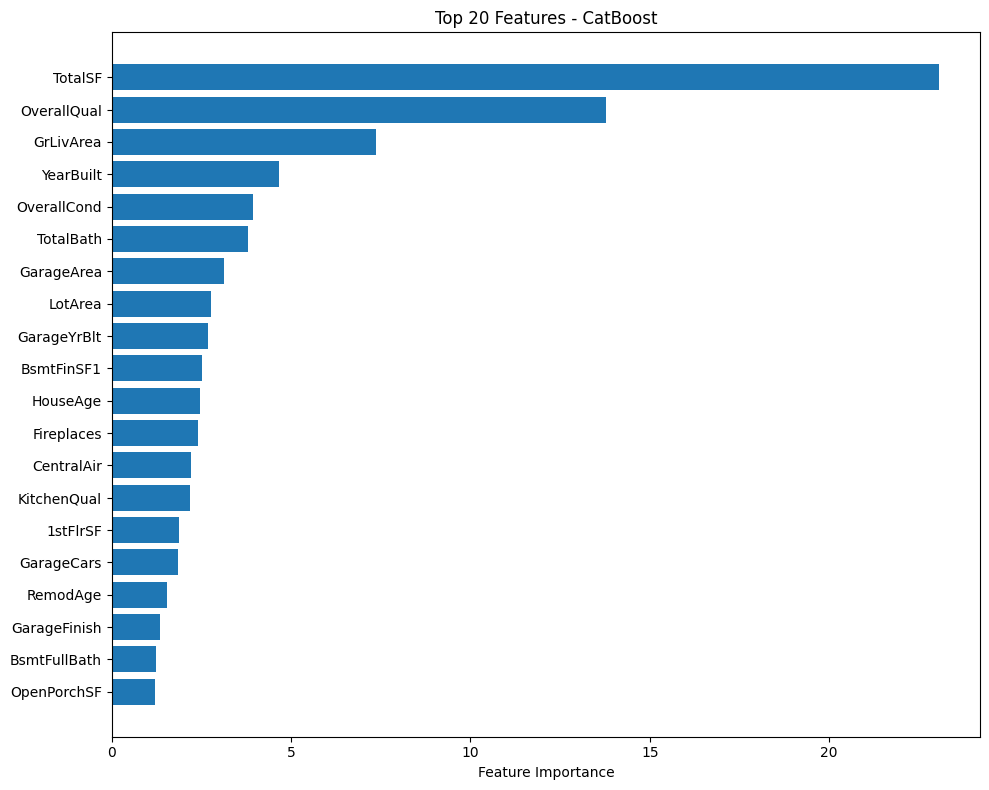

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Fit the model (if not already done)
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)

# Fit model with raw data and categorical indices
catboost_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# 2. Get feature importances
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns  # Use raw column names

# 3. Plot top 20 important features
top_n = 20
sorted_idx = np.argsort(feature_importances)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), np.array(feature_importances)[sorted_idx])
plt.yticks(range(top_n), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features - CatBoost")
plt.tight_layout()
plt.show()


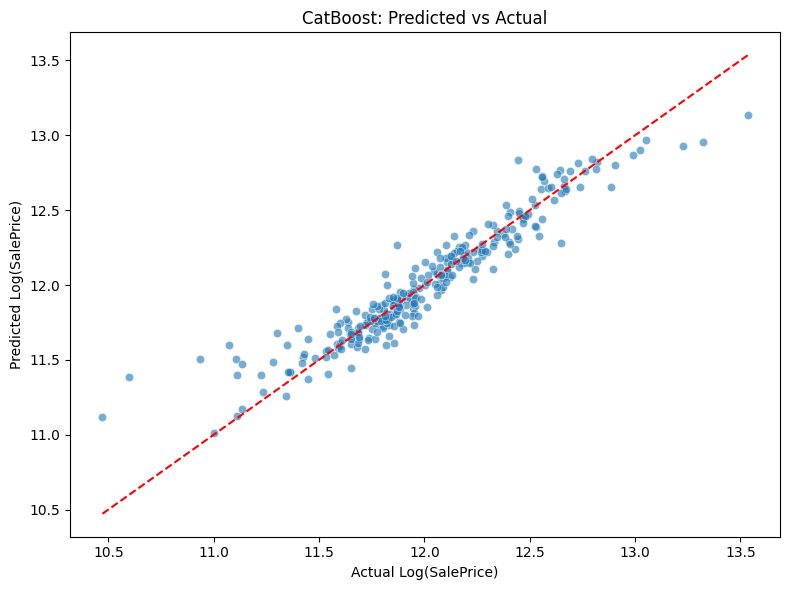

In [64]:
import seaborn as sns

y_pred = catboost_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Log(SalePrice)")
plt.ylabel("Predicted Log(SalePrice)")
plt.title("CatBoost: Predicted vs Actual")
plt.tight_layout()
plt.show()


In [71]:
final_model = Ridge(alpha=1.0)  # or CatBoostRegressor(...)
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", final_model)
])
final_pipeline.fit(X, y)


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('regressor', Ridge())])

In [72]:
import joblib

# Final training on full data
final_model = Ridge(alpha=1.0)  # or CatBoostRegressor(...)

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", final_model)
])

final_pipeline.fit(X, y)  # Train on full data

# Save it
joblib.dump(final_pipeline, "house_price_model.pkl")


c:\Users\zirad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['house_price_model.pkl']